In [2]:
import sys
sys.path.append("../")
import torch
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler

with torch.no_grad():
    model_id = "stabilityai/stable-diffusion-2-1-base"
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")
    pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
    print(pipe.scheduler)
    prompt = "a cute dog"
    guidance_scale = 7.0
    num_inference_steps=50
    num_images_per_prompt = 1
    prompt_embeds = None
    generator = None
    latents = None
    ###here we start to write the eidttable inference process
    if prompt is not None and isinstance(prompt, str):
        batch_size = 1
    elif prompt is not None and isinstance(prompt, list):
        batch_size = len(prompt)
    else:
        batch_size = prompt_embeds.shape[0]
    device = pipe._execution_device
    do_classifier_free_guidance = guidance_scale > 1.0
    prompt_embeds = pipe._encode_prompt(prompt,device,num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt = None,
            prompt_embeds = None,
            negative_prompt_embeds = None)
    # print(prompt_embeds.size())
    # print(prompt_embeds[0][0])
    # print(prompt_embeds[0][1])
    # prompt_embed_single = pipe._encode_prompt(prompt,device,1,
    #         0,
    #         negative_prompt = None,
    #         prompt_embeds = None,
    #         negative_prompt_embeds = None)
    # print(prompt_embed_single.size())
    # print(prompt_embeds[0][0])
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = pipe.scheduler.timesteps
    num_channels_latents = pipe.unet.in_channels
    height = pipe.unet.config.sample_size * pipe.vae_scale_factor
    width = pipe.unet.config.sample_size * pipe.vae_scale_factor
    latents = pipe.prepare_latents(
                batch_size * num_images_per_prompt,
                num_channels_latents,
                height,
                width,
                prompt_embeds.dtype,
                device,
                generator,
                latents,
            )
    num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order
    with pipe.progress_bar(total=num_inference_steps) as progress_bar:
        for i, t in enumerate(timesteps):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds,cross_attention_kwargs=None).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

            # call the callback, if provided
            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
                progress_bar.update()
        image = pipe.decode_latents(latents)
        image, has_nsfw_concept = pipe.run_safety_checker(image, device, prompt_embeds.dtype)
        image = pipe.numpy_to_pil(image)
        print( len(image) )

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

3


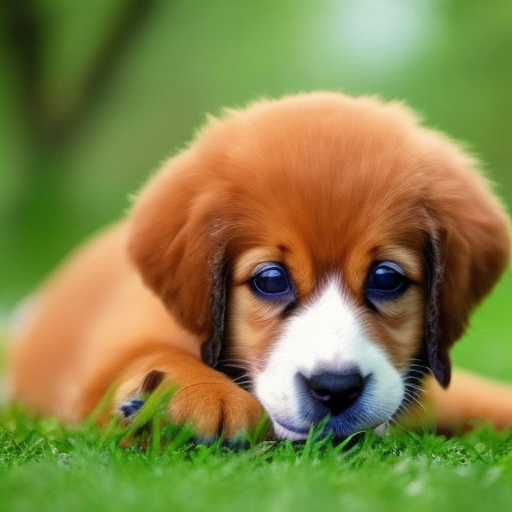